# Spatial Validation CESM LME

In [2]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [4]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils_kb as limkb
import LIM_building as limbuild
import LIM_stats_kb as statskb

sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [5]:
plt.rcParams['figure.dpi']=300

In [6]:
def get_title_strings(var,exp_setup,forecast):
    if 'cmip6' in exp_setup['train_dsource']: 
        tcmip='CMIP6'
    elif 'era' in exp_setup['train_dsource']:
        tcmip=''
    elif 'satellite' in exp_setup['train_dsource']: 
        tcmip=''
    elif 'lme' in exp_setup['train_dsource']: 
        tcmip=''
    else: 
        tcmip='CMIP5'

    if 'cmip6' in exp_setup['valid_dsource']: 
        vcmip='CMIP6'
    elif 'era' in exp_setup['valid_dsource']:
        vcmip=''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vcmip=''
    elif 'lme' in exp_setup['valid_dsource']: 
        vcmip=''
    else: 
        vcmip='CMIP5'

    # start_tim = exp_setup['nyears_startvalid']
    # end_tim = exp_setup['nyears_startvalid']+(exp_setup['nyearsvalid']*12)
    valid_yrs_str = (str(forecast['var_dict_valid'][var]['time'][0])[:4]+'_'+
                     str(forecast['var_dict_valid'][var]['time'][-1])[:4])

    if 'hist' in exp_setup['train_dsource']:
        texp = 'Historical'
    elif 'lm' in exp_setup['train_dsource']: 
        texp = 'LM'
    elif 'ssp585' in exp_setup['train_dsource']: 
        texp = 'SSP585'
    elif 'era5' in exp_setup['train_dsource']: 
        texp = 'ERA5'
    elif 'satellite' in exp_setup['train_dsource']: 
        texp = 'Satellite'
    elif 'lme' in exp_setup['train_dsource']: 
        texp = 'LME'

    if 'hist' in exp_setup['valid_dsource']:
        vexp = 'Historical'
    elif 'lm' in exp_setup['valid_dsource']: 
        vexp = 'LM'
    elif 'ssp585' in exp_setup['valid_dsource']: 
        vexp = 'SSP585'
    elif 'era5' in exp_setup['valid_dsource']: 
        vexp = 'ERA5'
    elif 'satellite' in exp_setup['valid_dsource']: 
        vexp = 'Satellite'
    elif 'lme' in exp_setup['valid_dsource']: 
        vexp = 'LME'

    if 'cesm2' in exp_setup['train_dsource']:
        tmod = 'CESM2'
    elif 'mpi' in exp_setup['train_dsource']: 
        tmod = 'MPI'
    elif 'gfdl' in exp_setup['train_dsource']: 
        tmod = 'GFDL'
    elif 'ccsm4' in exp_setup['train_dsource']: 
        tmod = 'CCSM4'
    elif 'era5' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'satellite' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'lme' in exp_setup['train_dsource']: 
        tmod = 'CESM'

    if 'cesm2' in exp_setup['valid_dsource']:
        vmod = 'CESM2'
    elif 'mpi' in exp_setup['valid_dsource']: 
        vmod = 'MPI'
    elif 'gfdl' in exp_setup['valid_dsource']: 
        vmod = 'GFDL'
    elif 'ccsm4' in exp_setup['valid_dsource']: 
        vmod = 'CCSM4'
    elif 'era5' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'lme' in exp_setup['valid_dsource']: 
        vmod = 'CESM'

    if exp_setup['Weight'] is True: 
        wt_addin = ' '
    else: 
        wt_addin = '(no area weighting)'

    if exp_setup['detrend'] is True: 
        tr_addin = ' '
    else: 
        tr_addin = ' (trended)'
        
    return tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, wt_addin, tr_addin

In [7]:
def load_validation_data(var, exp_setup, remove_climo=True, detrend=True, verbose=True):
    ## LOad Truth data: 
    fdic_valid = limkb.build_training_dic(exp_setup['valid_dsource'])
    v = {}
    tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])
    #        tecut = exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))
    if tecut <=0: 
        tecut = False
    print('tecut = '+str(tecut) +', tscut = '+str(exp_setup['nyears_startvalid']/12))

    X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=remove_climo, detrend=detrend, 
                               verbose=verbose,tscut=int(exp_setup['nyears_startvalid']/12), 
                               tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'])

    if var is 'sic':
        if np.nanmax(X_var)>1:
            print('Changing units of sic be a between 0 to 1')
            X_var = X_var/100
    
    return X_var

In [8]:
def calc_validation_stats_spatial(lag_int,var,X_var,exp_setup,forecast,LIMd):
    ## Calculate validation statistics: 
    [truth_anom, 
     forecast_anom] = limbuild.gather_truth_forecast_notime(lag_int,var,exp_setup['mo'],X_var,
                                                            forecast['x_forecast_dcomp'],
                                                            LIMd_is['var_dict'],insamp=exp_setup['Insamp'])


    print('Truth_anom shape: '+str(truth_anom.shape))
    print('Forecast_anom shape: '+str(forecast_anom.shape))

    corr=np.zeros(truth_anom.shape[0])
    ce=np.zeros(truth_anom.shape[0])

    for i in range(truth_anom.shape[0]):
        corr[i] = np.corrcoef(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))[0,1]
        ce[i] = LMR_utils.coefficient_efficiency(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))

    forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_is['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

    rmse = np.sqrt(np.nanmean((truth_anom-forecast_anom)**2,axis=1))

    corr_2d = np.reshape(corr,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    ce_2d = np.reshape(ce,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    rmse_2d = np.reshape(rmse,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    
    return corr_2d, ce_2d, rmse_2d

In [9]:
def plot_spatial_validation(ax, variable, lat, lon, title): 

        ax.set_title(title, fontsize=16)
        ax.coastlines()

        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())

        cf = ax.pcolormesh(lon,lat, variable ,cmap='RdBu_r', 
                           transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
        fig.colorbar(cf, ax=ax)
        
        return 

In [10]:
ntrunc = 50 # EOF truncation for individual fields (reduced-state space)
ntrunc_sic = 50
#nmodes = 15 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic = 50
#modes_sic = 20

mo='all'
#mo=0
lags = [1,2,3,4,5,6,7,8]

#model = 'satellite'
#model = 'cmip6_mpi_hist'
#model = 'era5'
model = 'cesm_lme'
lag_int = 1

# forecast lead time in months that defines the LIM training
tau = 1

# variables to include in the LIM (note "vars" is a Python command)
limvars = ['tas','psl','zg','tos','sit','sic']
#limvars = ['sic']

data_dir = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_hist/cesm1/'
data_dir_mpi = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_hist/mpi/'

In [13]:
folder = 'last_millennium/'
var_names = (str(ntrunc)+"_").join(limvars)+str(nmodes_sic)
var='sic'

filename_lme = ('LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1906_2005_tas50_'+
               'psl50_zg50_tos50_sit50_sic50_20211202.pkl')

filename_le = ('LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_2007_2082_tas50L40_'+
               'psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')

filename_mpi = ('LIMcast_cesm_lme_002_ntrain_850_1650_cmip6_mpi_hist_regridlme_validy_1851_2014_'+
                'tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202_2.pkl')

print('Loading '+data_dir+filename_lme)

experiment_lme =  pickle.load(open(data_dir+filename_lme, 'rb'))
# experiment_le =  pickle.load(open(data_dir+filename_le, 'rb'))
experiment_mpi =  pickle.load(open(data_dir_mpi+filename_mpi, 'rb'))

LIMd_lme = experiment_lme['LIMd']
exp_setup_lme = experiment_lme['forecast']['exp_setup']
forecast_lme = experiment_lme['forecast']
forecast_validation_lags_lme = experiment_lme['forecast_validation_lags']
ar1cast_lags_lme = experiment_lme['ar1cast_lags']

# LIMd_le = experiment_le['LIMd']
# exp_setup_le = experiment_le['forecast']['exp_setup']
# forecast_le = experiment_le['forecast']
# forecast_validation_lags_le = experiment_le['forecast_validation_lags']
# ar1cast_lags_le = experiment_le['ar1cast_lags']

LIMd_mpi = experiment_mpi['LIMd']
exp_setup_mpi = experiment_mpi['forecast']['exp_setup']
forecast_mpi = experiment_mpi['forecast']
forecast_validation_lags_mpi = experiment_mpi['forecast_validation_lags']
ar1cast_lags_mpi = experiment_mpi['ar1cast_lags']

[tcmip_lme, vcmip_lme, valid_yrs_str_lme, texp_lme, 
 vexp_lme, tmod_lme, vmod_lme, wt_addin_lme, tr_addin_lme] = get_title_strings(var,exp_setup_lme,forecast_lme)
# [tcmip_le, vcmip_le, valid_yrs_str_le, texp_le, 
#  vexp_le, tmod_le, vmod_le, wt_addin_le, tr_addin_le] = get_title_strings(var,exp_setup_le,forecast_le)   
[tcmip_mpi, vcmip_mpi, valid_yrs_str_mpi, texp_mpi, 
 vexp_mpi, tmod_mpi, vmod_mpi, wt_addin_mpi, tr_addin_mpi] = get_title_strings(var,exp_setup_mpi,forecast_mpi) 

Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid_hist/cesm1/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1906_2005_tas50_psl50_zg50_tos50_sit50_sic50_20211202.pkl


## LME 1906--2005 performance: 

Text(0.5, 1.0, 'Sea-ice Concentration')

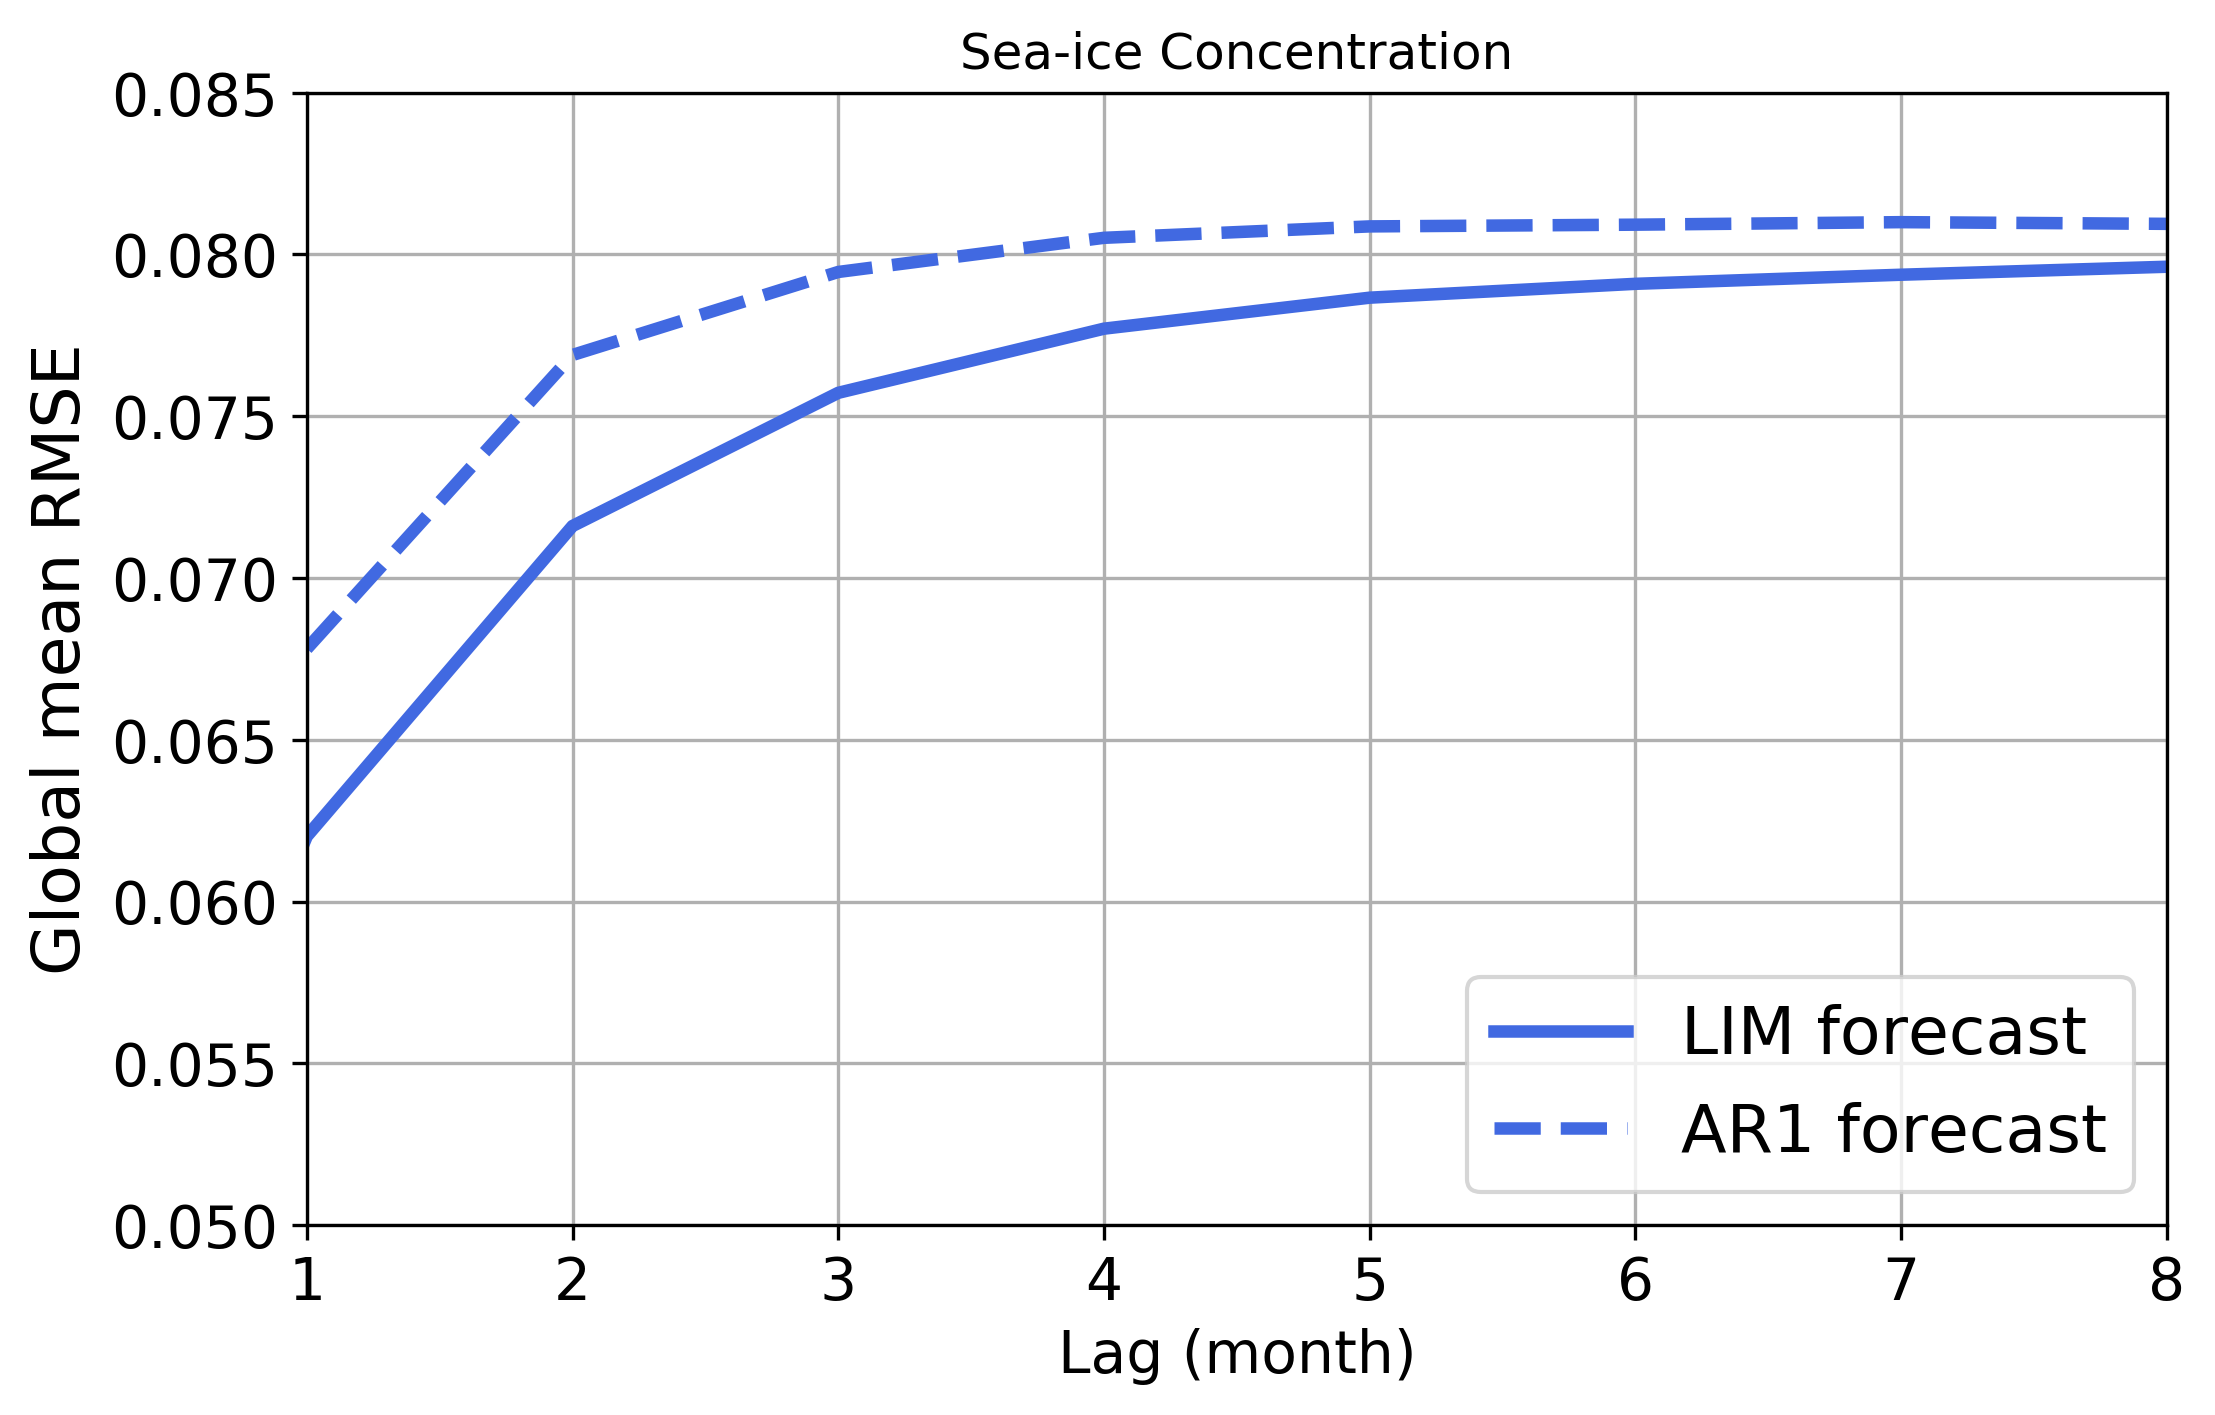

In [14]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,9,1),forecast_validation_lags_lme['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast', color='royalblue', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_lme['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast', color='royalblue', linewidth=3, linestyle='--')

plt.ylim(0.05,0.085)
plt.xlim(1,8)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Global mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='lower right',fontsize=16)
plt.title('Sea-ice Concentration')

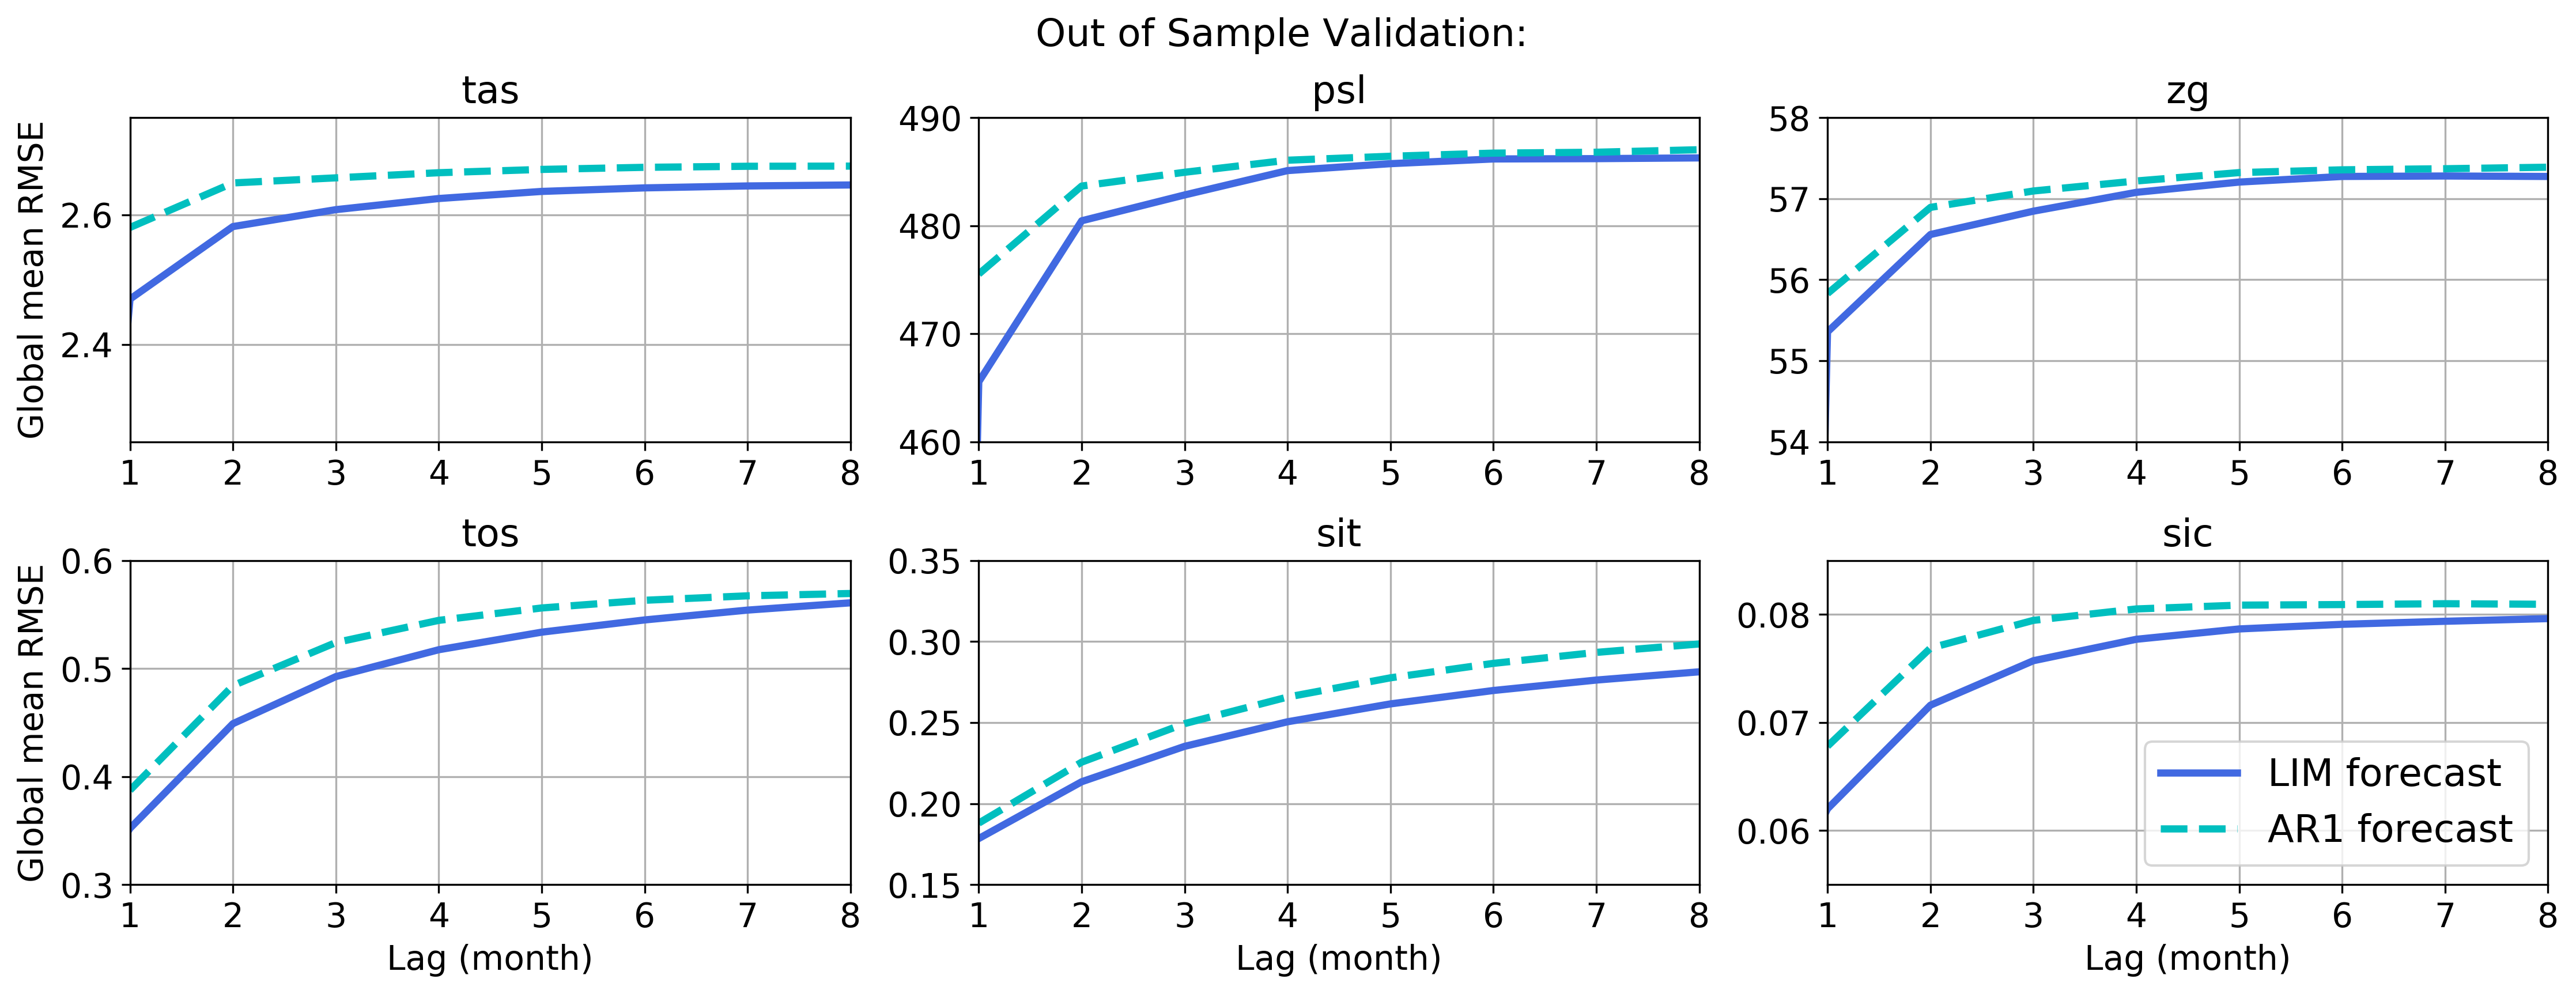

In [15]:
vmin = [2.25,460,54,0.3,0.15, 0.055]
vmax = [2.75,490,58,0.6,0.35, 0.085]

fig,axs = plt.subplots(2,3,figsize=(15,6))
ax = axs.flatten()

for i,var in enumerate(exp_setup_lme['limvars']):
    ax[i].grid(axis='both')

    ax[i].plot(np.arange(0,9,1),forecast_validation_lags_lme['validation_stats_lags'][var]['gm_rmse'], 
             label='LIM forecast', color='royalblue', linewidth=3)
    ax[i].plot(np.arange(1,9,1),ar1cast_lags_lme['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
             label='AR1 forecast', color='c', linewidth=3, linestyle='--')
    ax[i].set_xlim(1,8)
    ax[i].set_ylim(vmin[i],vmax[i])
    ax[i].set_title(var, fontsize=16)
    ax[i].tick_params(axis='both', which='major', labelsize=14)

# plt.ylim(0.05,0.085
ax[5].set_xlabel('Lag (month)', fontsize=14)
ax[3].set_xlabel('Lag (month)', fontsize=14)
ax[4].set_xlabel('Lag (month)', fontsize=14)

# plt.ylabel('Global mean RMSE',fontsize=16)
ax[0].set_ylabel('Global mean RMSE', fontsize=14)
ax[3].set_ylabel('Global mean RMSE', fontsize=14)

ax[5].legend(loc='lower right',fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.suptitle('Out of Sample Validation: ', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [23]:
var_labels = {'tas':'Temperature (K)','tos':'Sea Surface Temperature (K)','zg':'Geopotential Height (500 hPa) (m)','psl':'Sea Level Pressure (Pa)','sit':'Sea Ice Thickness (m)','sic':'Sea Ice Concentration (%)'}

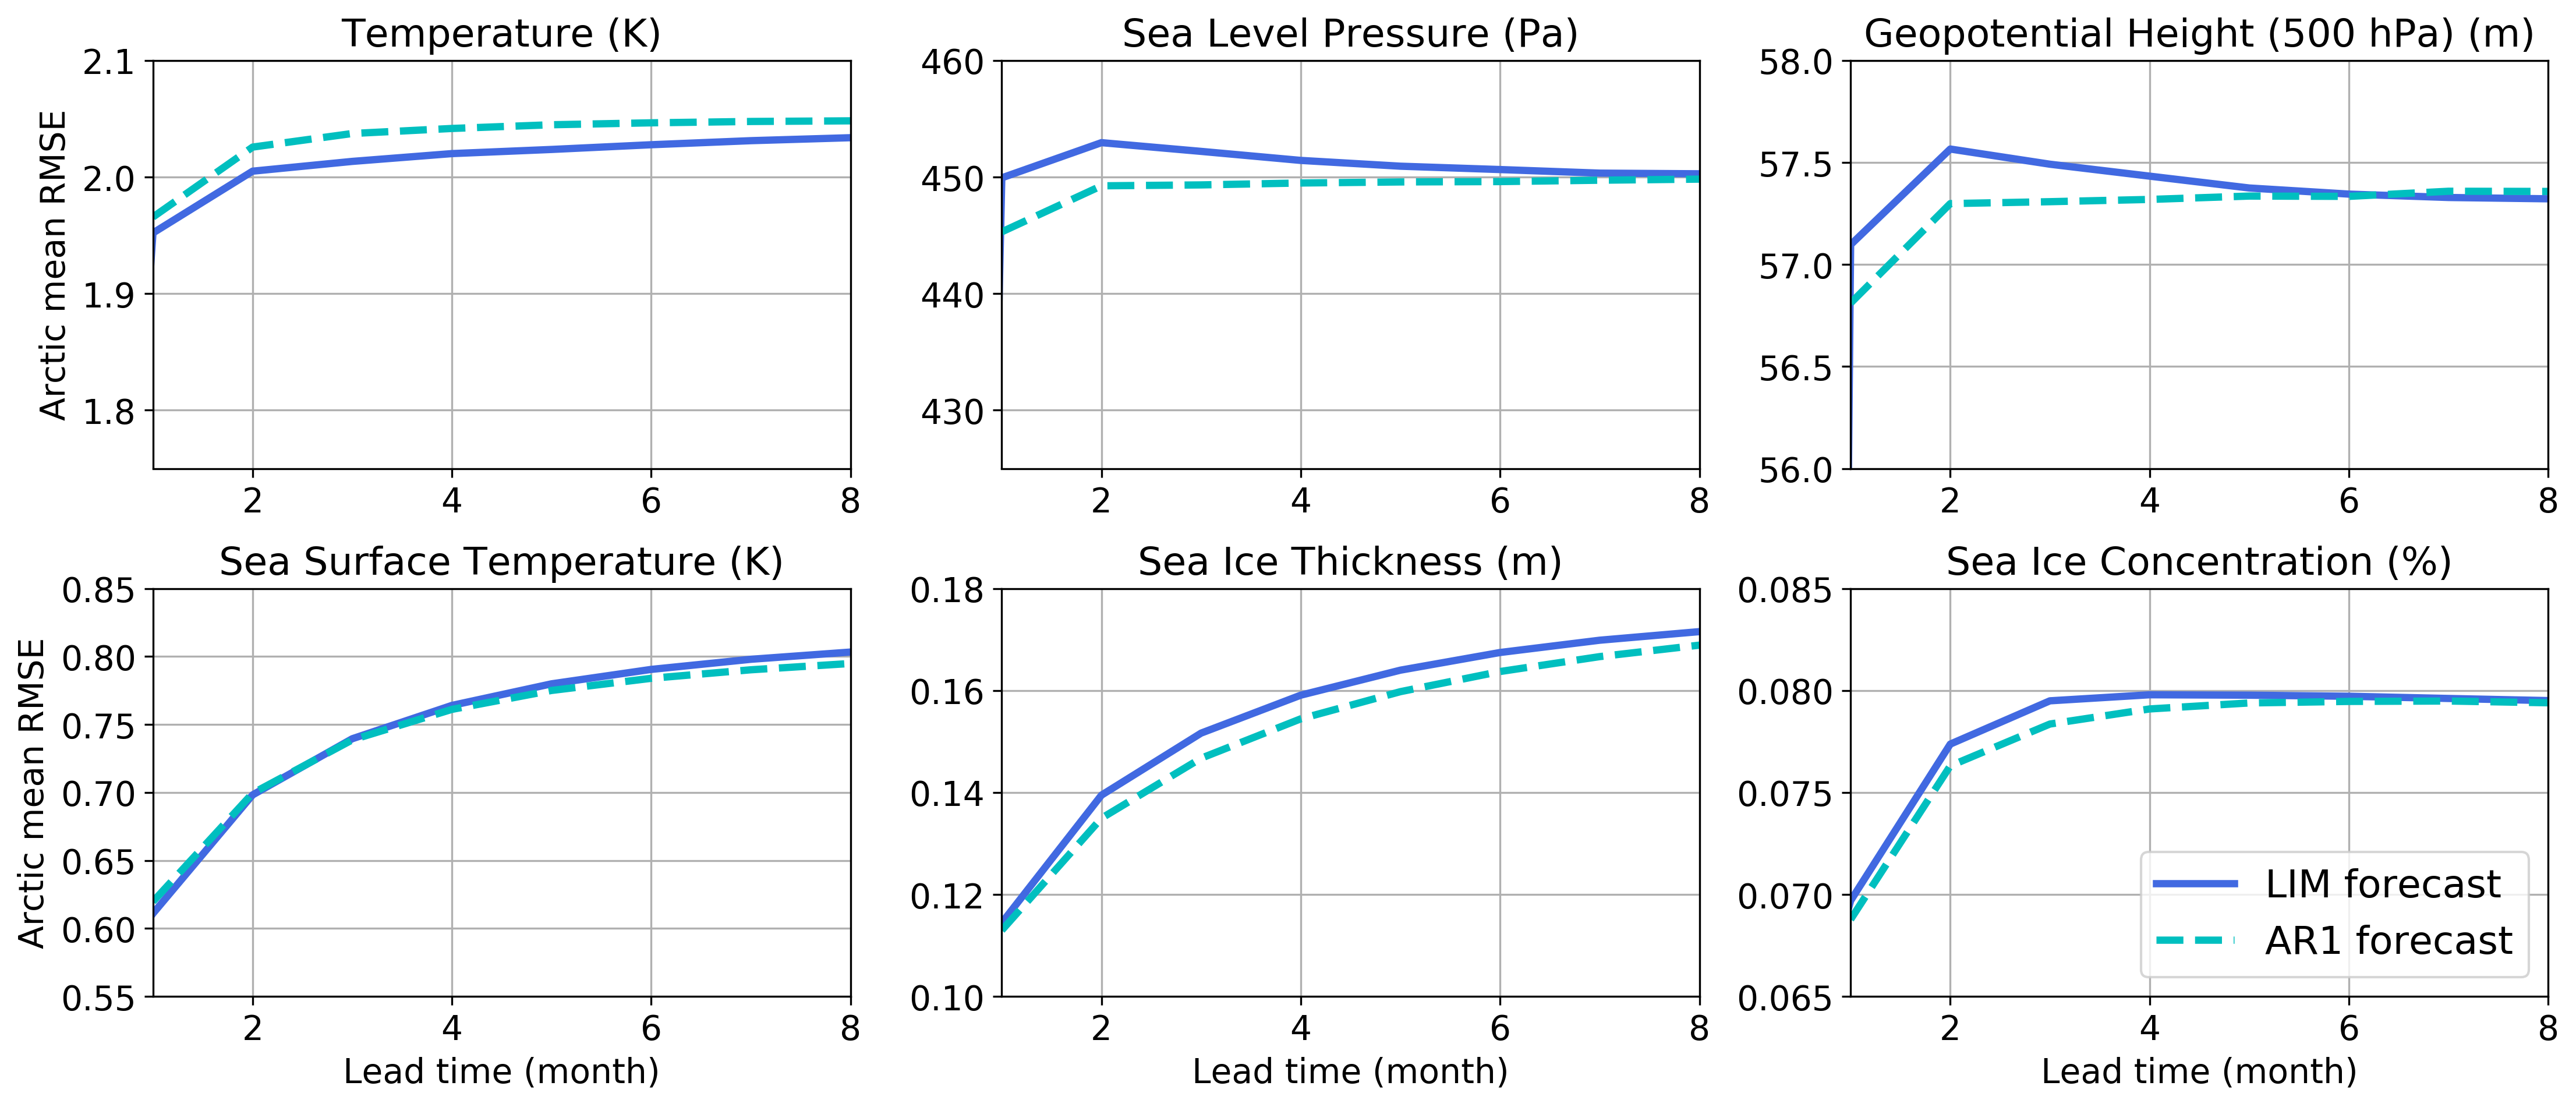

In [27]:
vmin = [1.75,425,56,0.55,0.1, 0.065]
vmax = [2.1,460,58,0.85,0.18, 0.085]

fig,axs = plt.subplots(2,3,figsize=(15,7))
ax = axs.flatten()

for i,var in enumerate(exp_setup_lme['limvars']):
    ax[i].grid(axis='both')

    ax[i].plot(np.arange(0,9,1),forecast_validation_lags_mpi['validation_stats_lags'][var]['gm_rmse'], 
             label='LIM forecast', color='royalblue', linewidth=3)
    ax[i].plot(np.arange(1,9,1),ar1cast_lags_mpi['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
             label='AR1 forecast', color='c', linewidth=3, linestyle='--')
    ax[i].set_xlim(1,8)
    ax[i].set_ylim(vmin[i],vmax[i])
    ax[i].set_title(var_labels[var], fontsize=16)
    ax[i].tick_params(axis='both', which='major', labelsize=14)

# plt.ylim(0.05,0.085
ax[5].set_xlabel('Lead time (month)', fontsize=14)
ax[3].set_xlabel('Lead time (month)', fontsize=14)
ax[4].set_xlabel('Lead time (month)', fontsize=14)

# plt.ylabel('Global mean RMSE',fontsize=16)
ax[0].set_ylabel('Arctic mean RMSE', fontsize=14)
ax[3].set_ylabel('Arctic mean RMSE', fontsize=14)

ax[5].legend(loc='lower right',fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.suptitle('Out of Sample Validation: ', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## LE 2007--2082 performance: 

Text(0.5,1,'Sea-ice Concentration')

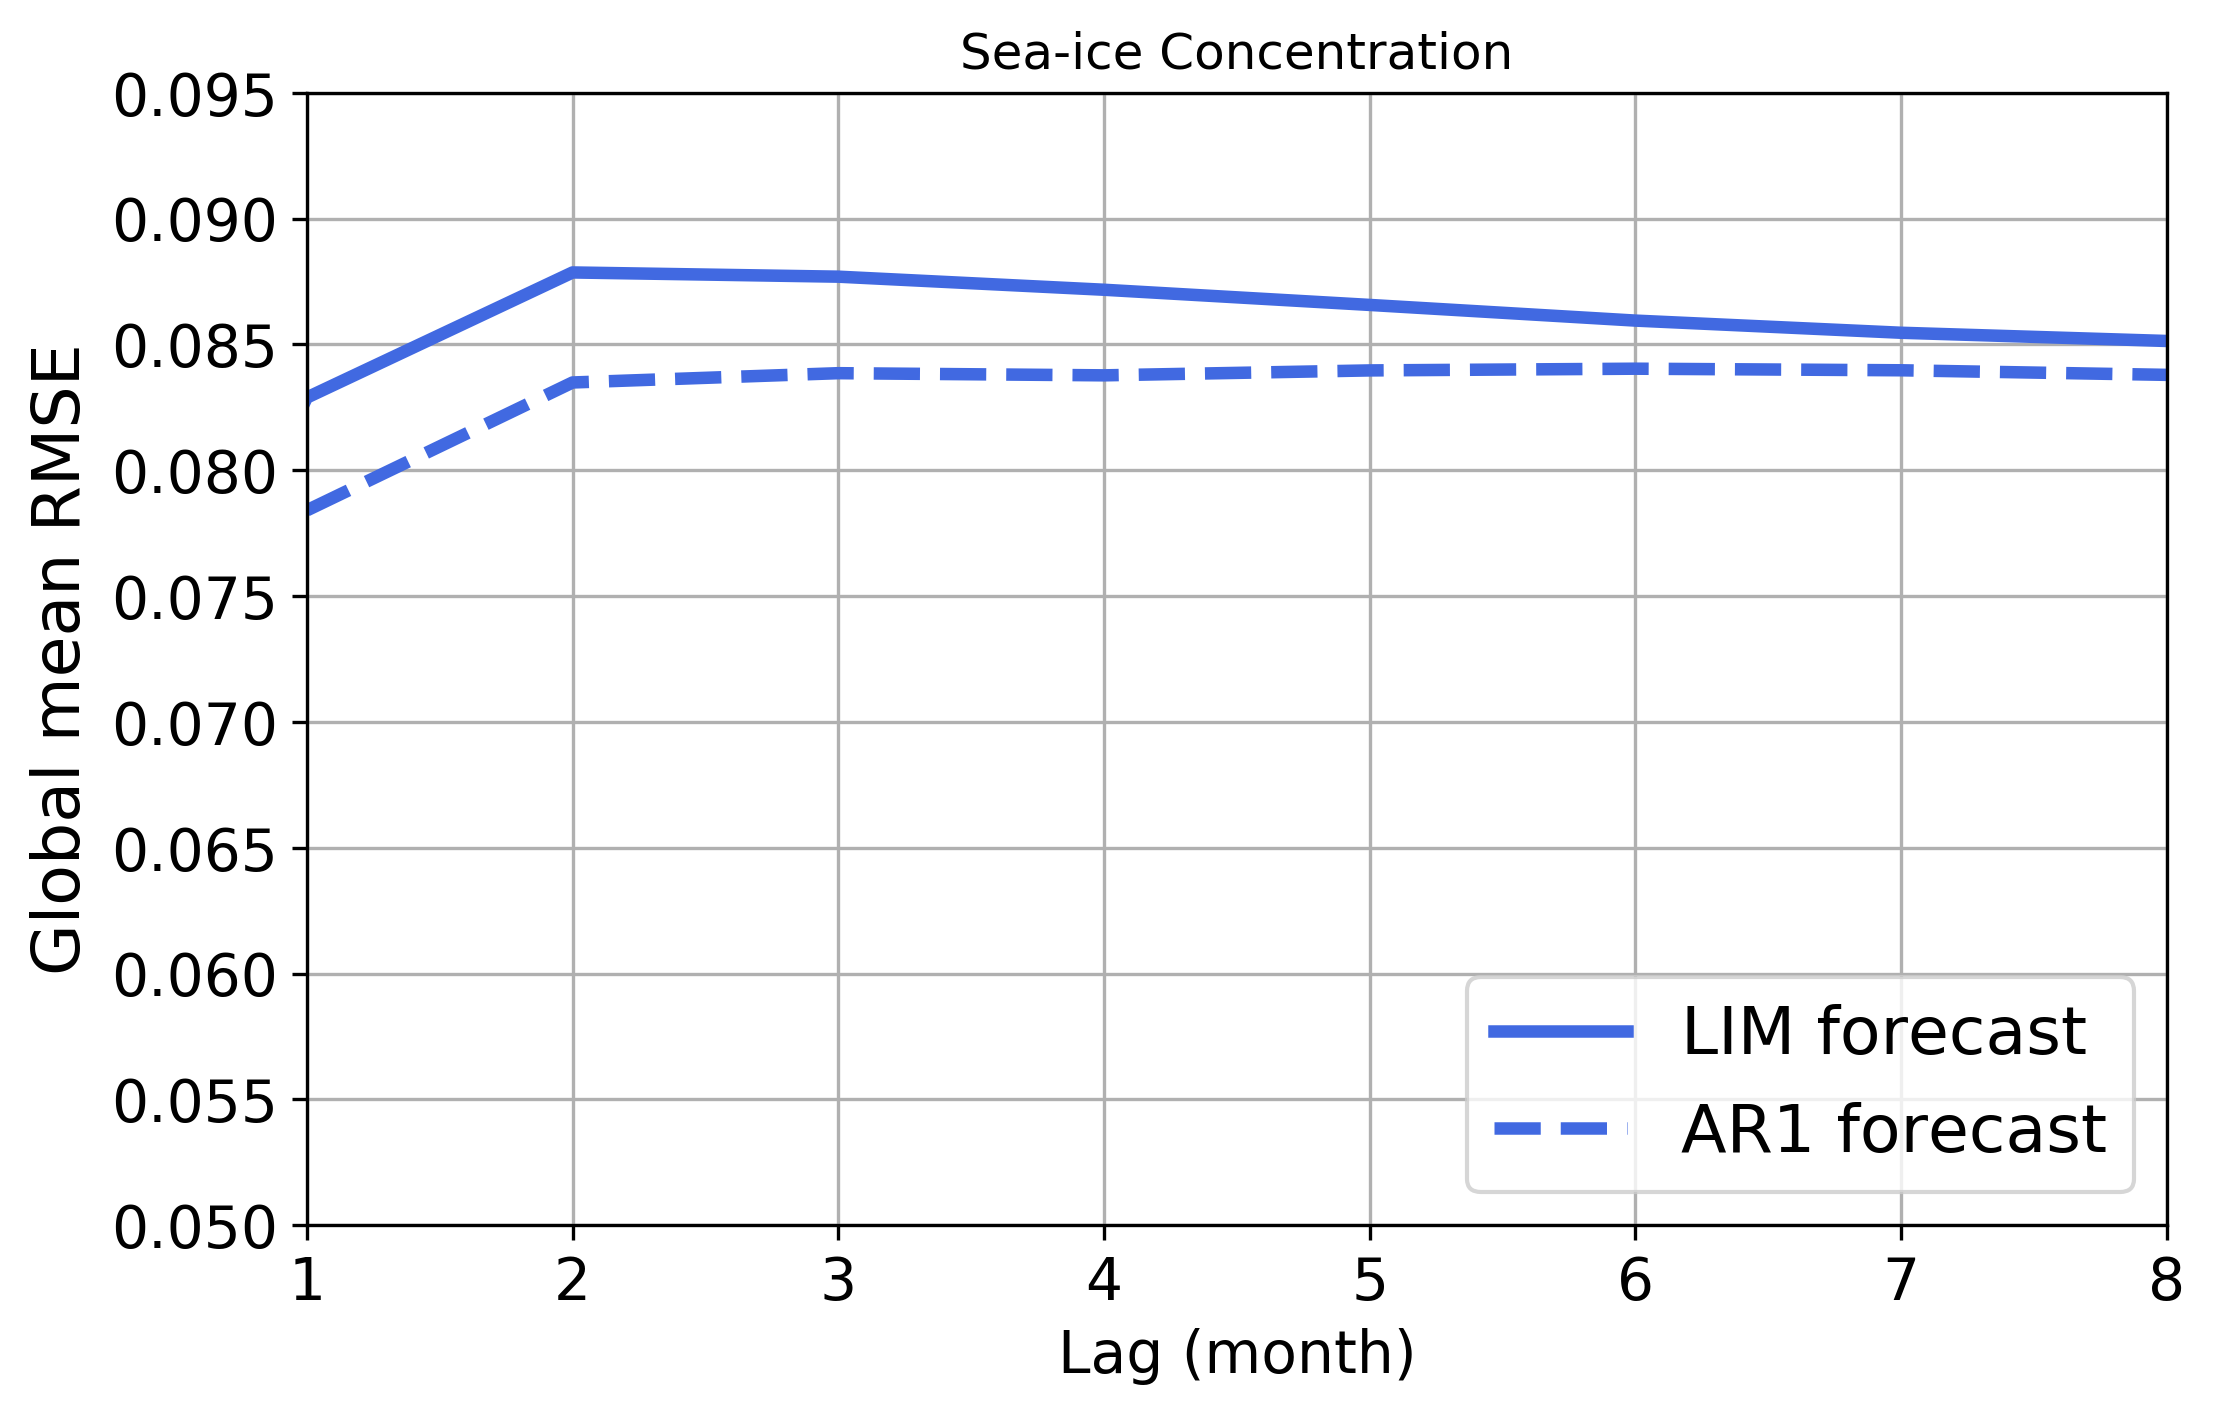

In [16]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,9,1),forecast_validation_lags_le['validation_stats_lags']['sic']['gm_rmse'], 
         label='LIM forecast', color='royalblue', linewidth=3)
plt.plot(np.arange(1,9,1),ar1cast_lags_le['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1], 
         label='AR1 forecast', color='royalblue', linewidth=3, linestyle='--')

plt.ylim(0.05,0.095)
plt.xlim(1,8)
plt.xlabel('Lag (month)', fontsize=14)
plt.ylabel('Global mean RMSE',fontsize=16)
#ax.set_xticks(ticks=np.arange(0,13,1))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='lower right',fontsize=16)
plt.title('Sea-ice Concentration')

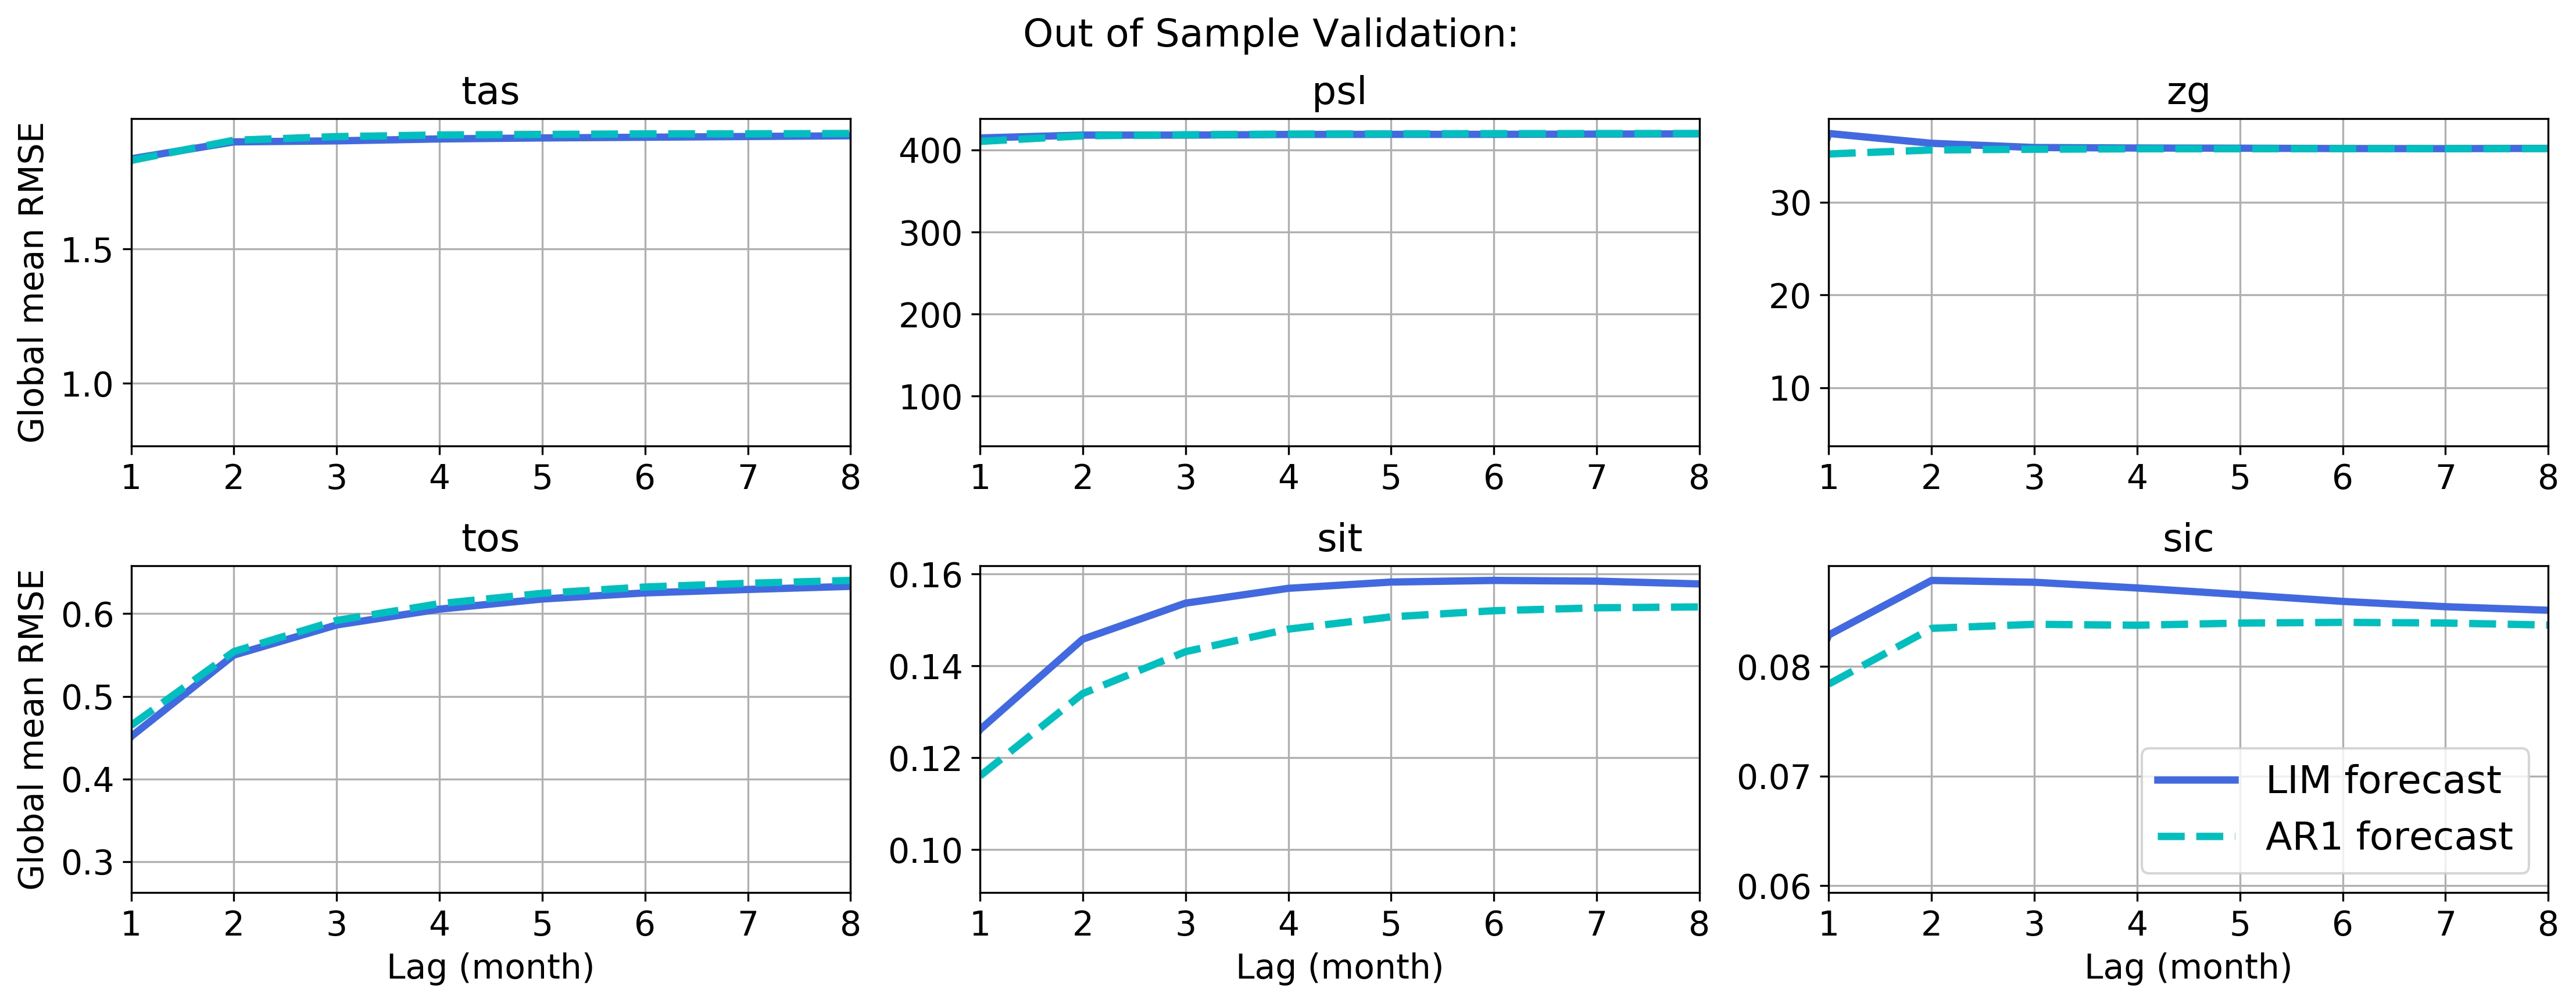

In [18]:
# vmin = [2.25,460,54,0.3,0.15, 0.055]
# vmax = [2.75,490,58,0.6,0.35, 0.085]

fig,axs = plt.subplots(2,3,figsize=(15,6))
ax = axs.flatten()

for i,var in enumerate(exp_setup_lme['limvars']):
    ax[i].grid(axis='both')

    ax[i].plot(np.arange(0,9,1),forecast_validation_lags_le['validation_stats_lags'][var]['gm_rmse'], 
             label='LIM forecast', color='royalblue', linewidth=3)
    ax[i].plot(np.arange(1,9,1),ar1cast_lags_le['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
             label='AR1 forecast', color='c', linewidth=3, linestyle='--')
    ax[i].set_xlim(1,8)
#    ax[i].set_ylim(vmin[i],vmax[i])
    ax[i].set_title(var, fontsize=16)
    ax[i].tick_params(axis='both', which='major', labelsize=14)

# plt.ylim(0.05,0.085
ax[5].set_xlabel('Lag (month)', fontsize=14)
ax[3].set_xlabel('Lag (month)', fontsize=14)
ax[4].set_xlabel('Lag (month)', fontsize=14)

# plt.ylabel('Global mean RMSE',fontsize=16)
ax[0].set_ylabel('Global mean RMSE', fontsize=14)
ax[3].set_ylabel('Global mean RMSE', fontsize=14)

ax[5].legend(loc='lower right',fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.suptitle('Out of Sample Validation: ', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])